Используя базу данных hh или квартир, пишем регрессионную модель, предсказывающую зарплату/цену на дом (на выбор).


## Библиотеки

In [ ]:
import numpy as np #Библиотека работы с массивами
import pandas as pd # Библиотека для работы с базами

from tensorflow.keras.models import Sequential, Model # загружаем модели 
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Embedding, Flatten, SpatialDropout1D, LSTM, Conv1D, MaxPooling1D
from tensorflow.keras import utils, backend #Используем для to_categoricall
from tensorflow.keras.optimizers import Adam,Adadelta,SGD,Adagrad,RMSprop # загружаем оптимизаторы
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence #
from tensorflow.keras.preprocessing.sequence import pad_sequences # для правильной обрезки и дополнения последовательностей
from tensorflow.keras.callbacks import LambdaCallback, Callback # подключаем колбэки

from sklearn.preprocessing import StandardScaler # для стандартизации данных 
from sklearn.model_selection import train_test_split # Для разбивки на выборки
from sklearn.metrics import mean_squared_error, mean_absolute_error # для расчёта погрешностей
#from google.colab import files #Для загрузки своей картинки

import random #Для генерации случайных чисел 
import math # Для округления
#import os #Для работы с файлами 
import re # для обработки текста
import matplotlib.pyplot as plt # отрисовка графиков
%matplotlib inline

# работа с визуализацией
from IPython.display import clear_output, SVG, Image
from tensorflow.keras.utils import plot_model, model_to_dot

import time # для подсчёта времени выполнения

In [ ]:
# Этим блоком будем визуализировать
from PIL import Image
import scipy
 
# Библиотеки Pytorch
import torch 
import torchvision # здесь лежит mnist, cifar и много других датасетов и трансформаций для картинок
import torch.nn as nn # здесь лежат все слои
import torch.utils.data as data # работа с загрузчиком данных
import torchvision.transforms as transforms
import torchvision.datasets as dsets #работа с классом Датасет
from torch.autograd import Variable # для автоматического дифференциатора
 
# Визуализации графа
from torch.utils.tensorboard import SummaryWriter 
import datetime,os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

###Функции парсинга

In [ ]:
#Во всех функция дальше
#d - описание квартиры, одна строка из data1


#Вычисляем количество комнат
#maxRoomCount - максимальное число комнат в квартире
def getRoomsCount(d, maxRoomCount):
  roomsCountStr = d[0] #Получаем строку с числом комнат

  roomsCount = 0
  try:
    roomsCount = int(roomsCountStr) #Пробуем превратить строку в число
    if (roomsCount > maxRoomCount): 
      roomsCount = maxRoomCount #Если число комнат больше максимального, то присваиваем максимальное
  except: #Если не получается превратить строку в число
    if (roomsCountStr == roomsCountStr): #Проверяем строку на nan (сравнение с самим собой)
      if ("Ст" in roomsCountStr): #ЕСть строка = "Ст", значит это Студия
        roomsCount = maxRoomCount + 1

  return roomsCount

#Превращаем число комнат в категорию
def getRoomsCountCategory(d, maxRoomCount):
  roomsCount = getRoomsCount(d, maxRoomCount) #Получаем число комнат
  roomsCount = utils.to_categorical(roomsCount, maxRoomCount+2) #Превращаем в категорию
  #maxRoomCount+2 потому что 0 зарезервирован на неопознаное число комнат, а maxRoomCount+1 на "Студию"
  return roomsCount

#Получаем индекс станции метро
#allMetroNames - все уникальные названия метро в базе
def getMetro(d, allMetroNames):
  metroStr = d[1] #Получаем строку метро
  metro = 0
  
  if (metroStr in allMetroNames): #Если находим метро во всех названиях
    metro = allMetroNames.index(metroStr)+1 #Присваиваем индекс
    #+1 так как 0 зарезервирован на неопознанное метро
    
  return metro

#Получаем тип метро
#0 - внутри кольца
#1 - кольцо
#2 - 1-3 станции от конца
#3 - 4-8 станций от кольца
#4 - больше 8 станций от кольца
def getMetroType(d):
  metroTypeStr = d[1] #Получаем строку метро
  metroTypeClasses = 5 #Число классов метро
  metroType = metroTypeClasses - 1 #Изначально считаем последний класс
  
  #Метро внутри кольца
  metroNamesInsideCircle = ["Площадь Революции", "Арбатская", "Смоленская", "Красные Ворота", "Чистые пруды", "Лубянка", "Охотный Ряд", "Библиотека имени Ленина", "Кропоткинская", "Сухаревская", "Тургеневская", "Китай-город", "Третьяковская", "Трубная", "Сретенский бульвар", "Цветной бульвар", "Чеховская", "Боровицкая", "Полянка", "Маяковская", "Тверская", "Театральная", "Новокузнецкая", "Пушкинская", "Кузнецкий Мост", "Китай-город", "Александровский сад"]
  #Метро на кольце
  metroNamesCircle = ["Киевская", "Парк Культуры", "Октябрьская", "Добрынинская", "Павелецкая", "Таганская", "Курская", "Комсомольская", "Проспект Мира", "Новослободская", "Белорусская", "Краснопресненская"]
  #Метро 1-3 станции от кольца
  metroNames13FromCircle = ["Бауманская", "Электрозаводская", "Семёновская", "Площадь Ильича", "Авиамоторная", "Шоссе Энтузиастов", "Римская", "Крестьянская Застава", "Дубровка", "Пролетарская", "Волгоградский проспект", "Текстильщики", "Автозаводская", "Технопарк", "Коломенская", "Тульская", "Нагатинская", "Нагорная", "Шаболовская", "Ленинский проспект", "Академическая", "Фрунзенская", "Спортивная", "Воробьёвы горы", "Студенческая", "Кутузовская", "Фили", "Парк Победы", "Выставочная", "Международная", "Улица 1905 года", "Беговая", "Полежаевская", "Динамо", "Аэропорт", "Сокол", "Деловой центр", "Шелепиха", "Хорошёвская", "ЦСКА", "Петровский парк", "Савёловская", "Дмитровская", "Тимирязевская", "Достоевская", "Марьина Роща", "Бутырская", "Фонвизинская", "Рижская", "Алексеевская", "ВДНХ", "Красносельская", "Сокольники", "Преображенская площадь"]
  #Метро 4-8 станций от кольа
  metroNames48FromCircle = ["Партизанская", "Измайловская", "Первомайская", "Щёлковская", "Новокосино", "Новогиреево", "Перово", "Кузьминки", "Рязанский проспект", "Выхино", "Лермонтовский проспект", "Жулебино", "Партизанская", "Измайловская", "Первомайская", "Щёлковская", "Новокосино", "Новогиреево", "Перово", "Кузьминки", "Рязанский проспект", "Выхино", "Лермонтовский проспект", "Жулебино", "Улица Дмитриевского", "Кожуховская", "Печатники", "Волжская", "Люблино", "Братиславская", "Коломенская", "Каширская", "Кантемировская", "Царицыно", "Орехово", "Севастопольская", "Чертановская", "Южная", "Пражская", "Варшавская", "Профсоюзная", "Новые Черёмушки", "Калужская", "Беляево", "Коньково", "Университет", "Багратионовская", "Филёвский парк", "Пионерская", "Кунцевская", "Молодёжная", "Октябрьское Поле", "Щукинская", "Спартак", "Тушинская", "Сходненская", "Войковская", "Водный стадион", "Речной вокзал", "Беломорская", "Ховрино", "Петровско-Разумовская", "Владыкино", "Отрадное", "Бибирево", "Алтуфьево", "Фонвизинская", "Окружная", "Верхние Лихоборы", "Селигерская", "ВДНХ", "Ботанический сад", "Свиблово", "Бабушкинская", "Медведково", "Преображенская площадь", "Черкизовская", "Бульвар Рокоссовского"]
  
  #Проверяем, в какую категорию попадает наша станция
  if (metroTypeStr in metroNamesInsideCircle):
    metroType = 0
  if (metroTypeStr in metroNamesCircle):
    metroType = 1
  if (metroTypeStr in metroNames13FromCircle):
    metroType = 2
  if (metroTypeStr in metroNames48FromCircle):
    metroType = 3
  
  #Превращаем результат в категорию
  metroType = utils.to_categorical(metroType, metroTypeClasses)
  return metroType


#Вычисляем растояние до метро
def getMetroDistance(d):
  metroDistanceStr = d[2] #Получаем строку
  
  metroDistance = 0 #Расстояние до метро
  metroDistanceType = 0 #Тип расстояния - пешком или на транспорте
  
  #ЕСли строка не равна nan  
  if (metroDistanceStr == metroDistanceStr):
    if (len(metroDistanceStr) > 0):
      #Определяем тип расстояния
      if (metroDistanceStr[-1] == "п"):
        metroDistanceType = 1 #Пешком
      elif (metroDistanceStr[-1] == "т"):
        metroDistanceType = 2 #На транспорте

      #Выбрасываем последний символ, чтобы осталось только число
      metroDistanceStr = metroDistanceStr[:-1]
      try:
        #Разделяем дистанции на категории
        metroDistance = int(metroDistanceStr)
        if (metroDistance < 3):
          metroDistance = 1
        elif (metroDistance < 6):
          metroDistance = 2
        elif (metroDistance < 10):
          metroDistance = 3
        elif (metroDistance < 15):
          metroDistance = 4
        elif (metroDistance < 20):
          metroDistance = 5
        else:
          metroDistance = 6
      except: #Если в строке не число, то категория 0
        metroDistance = 0
  
  #Число классов дистанции
  metroDistanceClasses = 7
  
  #У нас 7 категорий дистанции по расстоянию
  #И 3 типа дистанции - неопознанный, пешком и транспортом
  #Мы создадим вектор длины 3*7 = 21
  #Будем преобразовывать индекс расстояния 0-6 в 0-20
  #Для типа "Пешком" - ничего не меняем
  if (metroDistanceType == 2):
    metroDistance += metroDistanceClasses #Для типа "Транспортом" добавляем 7
  if (metroDistanceType == 0):
    metroDistance += 2*metroDistanceClasses #Для неопознанного типа добавляем 14
    
  #Превращаем в категории
  metroDistance = utils.to_categorical(metroDistance, 3*metroDistanceClasses)
  return metroDistance

#Получаем 4 данных
#- этаж квартиры
#- этажность дома
#- индикатор, что последний этаж
#- тип дома
def getHouseTypeAndFloor(d):
  try:
    houseStr = d[3] #Получаем строку типа дома и этажей
  except:
    houseStr = ""
  
  houseType = 0 #Тип дома
  floor = 0 #Этаж квартиры
  floors = 0 #Этажность дома
  isLastFloor = 0 #Индикатор последнего этажа
  
  #Проверяем строку на nan
  if (houseStr == houseStr):
    if (len(houseStr) > 1):
    
      try:
        slashIndex = houseStr.index("/") #Ищем разделитель /
      except:
        print(houseStr)

      try:
        spaceIndex = houseStr.index(" ") #Ищем разделитель " "
      except:
        print(houseStr)

      #Вытаскиваем строки
      floorStr = houseStr[:slashIndex] #Строка этажа
      floorsStr = houseStr[slashIndex+1:spaceIndex] #Строка этажнгости дома
      houseTypeStr = houseStr[spaceIndex+1:] #Строка типа дома

      #Выбираем категорию этажа
      try:
        floor = int(floorStr) #Превращаем строку в число
        floorSave = floor
        if (floorSave < 5):
          floor = 2
        if (floorSave < 10):
          floor = 3
        if (floorSave < 20):
          floor = 4
        if (floorSave >= 20):
          floor = 5
        if (floorSave == 1): #Первый этаж выделяем в отдельную категорию
          floor = 1 

        if (floor == floors): #Если этаж последний, включаем индикатор последнего этажа
          isLastFloor = 1 
      except:
        floor = 0 #Если строка не парсится в число, то категория этажа = 0 (отдельная)

      #Выбираем категорию этажности дома
      try:
        floors = int(floorsStr) #Превращаем строку в число
        floorsSave = floors
        if (floorsSave < 5):
          floors = 1
        if (floorsSave < 10):
          floors = 2
        if (floorsSave < 20):
          floors = 3
        if (floorsSave >= 20):
          floors = 4
      except:
        floors = 0 #Если строка не парсится в число, то категория этажности = 0 (отдельная)

      #Определяем категорию типа дома
      if (len(houseTypeStr) > 0):
        if ("М" in houseTypeStr): 
          houseType = 1
        if ("К" in houseTypeStr): 
          houseType = 2
        if ("П" in houseTypeStr): 
          houseType = 3
        if ("Б" in houseTypeStr): 
          houseType = 4
        if ("?" in houseTypeStr): 
          houseType = 5
        if ("-" in houseTypeStr): 
          houseType = 6
    
    #Превращаем все категории в one hot encoding
    floor = utils.to_categorical(floor, 6)
    floors = utils.to_categorical(floors, 5)
    houseType = utils.to_categorical(houseType, 7)
    
    
  return floor, floors, isLastFloor, houseType


#Вычисляем тип балкона
def getBalcony(d):
  balconyStr = d[4] #Полуаем строку
  #Выписываем все варианты балконов в базе
  balconyVariants = ['Л', 'Б', '2Б', '-', '2Б2Л', 'БЛ', '3Б', '2Л', 'Эрк', 'Б2Л', 'ЭркЛ', '3Л', '4Л', '*Л', '*Б']
  #Проверяем на nan
  if (balconyStr == balconyStr):
    balcony = balconyVariants.index(balconyStr)+1 #Находим индекс строки балкона во всех строках
  else:
    balcony = 0 #Индекс 0 выделяем на строку nan
  
  #Превращаем в one hot encoding
  balcony = utils.to_categorical(balcony, 16)
  
  return balcony

#Определяем тип санузла
def getWC(d):
  wcStr = d[5] #Получаем строку
  #Выписываем все варианты санузлов в базе
  wcVariants = ['2', 'Р', 'С', '-', '2С', '+', '4Р', '2Р', '3С', '4С', '4', '3', '3Р']
  #Проверяем на nan
  if (wcStr == wcStr):
    wc = wcVariants.index(wcStr)+1 #Находим индекс строки санузла во всех строках
  else:
    wc = 0 #Индекс 0 выделяем на строку nan
  
  #Превращаем в one hot encoding
  wc = utils.to_categorical(wc, 14)
  
  return wc

#Определяем площадь
def getArea(d):
  areaStr = d[6] #Поулачем строку площади
  
  if ("/" in areaStr):
    slashIndex = areaStr.index("/") #Находим разделитель /
    try:
      area = float(areaStr[:slashIndex]) #Берём число до разделителя и превращаем в число
    except:
      area = 0 #Если не получается, возвращаем 0
  else:
    area = 0 #Или если нет разделителя, возвращаем 0
    
  return area

#Полуаем цену
def getCost(d):
  costStr = d[7] #Загружаем строку
  
  try:
    cost = float(costStr) #Пробуем превратить в число
  except:
    cost = 0 #Если не получается, возвращаем 0
  
  return cost

#Получаем комментарий
def getComment(d):
  commentStr = d[-1] #Возвращаем данные из последней колонки
  
  return commentStr

#Объединяем все числовые параметры вместе
def getAllParameters(d, allMetroNames):
  #Загружаем все данные по отдельности
  roomsCountType = getRoomsCountCategory(d, 30)
  metro = getMetro(d, allMetroNames)
  metroType = getMetroType(d)
  metroDistance = getMetroDistance(d)
  floor, floors, isLastFloor, houseType = getHouseTypeAndFloor(d)
  balcony = getBalcony(d)
  wc = getWC(d)
  area = getArea(d)

  #Объединяем в один лист
  out = list(roomsCountType)
  out.append(metro)
  out.extend(metroType)
  out.extend(metroDistance)
  out.extend(floor)
  out.extend(floors)
  out.append(isLastFloor)
  out.extend(houseType)
  out.extend(balcony)
  out.extend(wc)
  out.append(area)
  
  return out

#Генерируем обучающаюу выборку - xTrain
def getXTrain(data):
  
  #Получаем строку во всеми вариантами метро
  allMertroNames = list(df["Метро / ЖД станции"].unique())
  
  #Всевращаем все строки в data1 в векторы параметров и записываем в xTrain
  xTrain = [getAllParameters(d, allMertroNames) for d in data]
  xTrain = np.array(xTrain)
  
  return xTrain

#Генерируем обучающую выборку - yTrain
def getYTrain(data):
  
  #Зашружаем лист всех цен квартир по всем строкам data1
  costList = [getCost(d) for d in data] 
  yTrain = np.array(costList)
  
  return yTrain

###Парсинг текста

In [ ]:
###########################
# Очистка текста и превращение в набор слов
##########################
def text2Words(text):

  #Удаляем лишние символы
  text = text.replace(".", "")
  text = text.replace("—", "")
  text = text.replace(",", "")
  text = text.replace("!", "")
  text = text.replace("?", "")
  text = text.replace("…", "")
  text = text.lower() #Переводим в нижний регистр
  
  
  words = [] #Тут будут все слов
  currWord = "" #Тут будет накапливаться текущее слово, между двумя пробелами
  
  #идём по всем символам
  for symbol in text:
    
    if (symbol != "\ufeff"): #Игнорируем системынй символ в начале строки
      if (symbol != " "): #Если символ не пробел
        currWord += symbol #То добавляем вимвол в текущее слово
      else: #Если символ пробел
        if (currWord != ""): 
          words.append(currWord) #Добавляем тккущее слово в список слов
          currWord = "" #И обнуляем текущее слово

  #Добавляем финальное слово, если оно не пустое
  #Если не сделать, то потеряем финальное слово, потому что текст чаще всего заканчивается на не пробел
  if (currWord != ""):
        words.append(currWord)
  
  return words


###########################
# Создание словаря - все слова, упорядоченные по частоте появления
##########################
def createVocabulary(allWords):
  
  #Создаём словарь, в котором будут слова и количество их поялвений во всём текста
  #Ключи - все наши слова
  #Количество появлений пока везде 0
  wCount = dict.fromkeys(allWords, 0)

  #Проходим по всем словам
  for word in allWords:
    wCount[word] += 1 #И увеличиаем количество появлений текущего слова на 1

  #Выцепляем лист из словаря
  wordsList = list(wCount.items())
  #И сортируем по частоте появления
  wordsList.sort(key = lambda i:i[1], reverse=1)
  #key = lambda i:i[1] - говорит, что сортировать надо по частоте появления
  #В i[0] у нас слово, в i[1] - частота появления
  #reverse=1 говорить сортироваться по убыванию

  sortedWords = [] #Тут будет лист всех отсортированных слов

  #Проходим по всем словам в отсортированном списке
  for word in wordsList:
    sortedWords.append(word[0]) #Докидываем слово в лист отсортированных слов

  #Это словарь слово - индекс
  #Изначально заполнен всеми словами
  #У всех индекс 0
  wordIndexes = dict.fromkeys(allWords, 0)
  #Проходим по всем словам
  for word in wordIndexes.keys():
    wordIndexes[word] = sortedWords.index(word)+1 #Ставим индекс = индекс слова в отсортированном листе слов + 1
    #+1 потому, что индекс 0 резервируем под неопознанные слова

  return wordIndexes


###########################
# Преобразования листа слов в лист индексов
##########################
def words2Indexes(words, vocabulary, maxWordsCount):
  wordsIndexes = []
  
  #Идём по всем словая
  for word in words:
    
    wordIndex = 0 #Тут будет индекс слова, изначально 0 - слово неопознано
    wordInVocabulary = word in vocabulary #Проверяем, есть ли слово в словаре
    
    #Если слово есть в словаре
    if (wordInVocabulary):
      index = vocabulary[word] #Индекс = индексу слова в словаре
      if (index < maxWordsCount): #Если индекс ниже maxWordsCount - черты отсечения слов
        wordIndex = index #То записываем индекс
      #Иначе останется значение 0
        
    wordsIndexes.append(wordIndex)
    
  return wordsIndexes


###########################
# Преобразование одного короткого вектора в вектор из 0 и 1
# По принципу words bag
##########################
def changeXTo01(trainVector, wordsCount):
  #Создаём вектор длины wordsCount с нулями
  out = np.zeros(wordsCount)
  
  #Идём по всем индексам в строке
  for x in trainVector:
    out[x] = 1 #В позицию нужного индекса ставим 1
    
  return out


###########################
# Преобразование выборки (обучающей или проверочной) к виду 0 и 1
# По принципу words bag
##########################
def changeSetTo01(trainSet, wordsCount):
  out = []
  
  #Проходим по всем векторам в наборе
  for x in trainSet:
    out.append(changeXTo01(x, wordsCount)) #Добавляем в итоговый набор текущий вектор, преобразованный в bag of words
    
  return np.array(out)


###########################
# Формируем обучающую выборку из примечаний к квартирам
# Пока в виде слов
##########################
def getXTrainComments(data):
  xTrainComments = [] #Тут будет обучающся выборка
  allTextComments = "" #Тут будуте все тексты вместе для словаря
  
  #Идём по всем строкам квартир в базе
  for d in data:
    currText = getComment(d) #Вытаскиваем примечание к квартире
    try: 
      if (currText == currText): #Проверяем на nan
        allTextComments += currText + " " #Добавляем текст в общий текст для словаря
    except:
      currText = "Нет комментария" #Если не получается, то делаем стандартный текст "Нет комментария"
    xTrainComments.append(currText) #Добавляем примечание новой строкой в обучающую выборку
  
  xTrainComments = np.array(xTrainComments)
  
  return (xTrainComments, allTextComments)

###########################
# Формируем обучающую выборку из примечаний к квартирам
# Теперь в виде индексов
##########################
def changeSetToIndexes(xTrainComments, vocabulary, maxWordsCount):
  xTrainCommentsIndexes = [] #Тут будет итоговый xTrain примечаний в виде индексов
  
  #Идём по всем текстам
  for text in xTrainComments:
    currWords = text2Words(text) #Разбиваем текст на слова
    currIndexes = words2Indexes(currWords, vocabulary, maxWordsCount) #Превращаем в лист индексов
    currIndexes = np.array(currIndexes)
    xTrainCommentsIndexes.append(currIndexes) #Добавляем в xTrain
  
  xTrainCommentsIndexes = np.array(xTrainCommentsIndexes)
  xTrainCommentsIndexes = changeSetTo01(xTrainCommentsIndexes, maxWordsCount) #Превращаем в формат bag of words
  return xTrainCommentsIndexes

###########################
# Формируем обучающую выборку из примечаний к квартирам
# Теперь в виде индексов
# И с приведением к стандартной длине всех векторов - cropLen
##########################
def changeSetToIndexesCrop(xTrainComments, vocabulary, maxWordsCount, cropLen):
  xTrainCommentsIndexes = [] #Тут будет итоговый xTrain примечаний в виде индексов
  
  #Идём по всем текстам
  for text in xTrainComments:
    currWords = text2Words(text) #Разбиваем текст на слова
    currIndexes = words2Indexes(currWords, vocabulary, maxWordsCount) #Превращаем в лист индексов
    currIndexes = np.array(currIndexes)
    xTrainCommentsIndexes.append(currIndexes) #Добавляем в xTrain
  
  xTrainCommentsIndexes = np.array(xTrainCommentsIndexes)
  xTrainCommentsIndexes = pad_sequences(xTrainCommentsIndexes, maxlen=cropLen) #Приводим все вектора к стандартной длине
  return xTrainCommentsIndexes

## Загрузка данных

In [ ]:
# Копируем несжатые данные в колаб
!cp  '/content/drive/My Drive/datasets/moscow.csv' /content/moscow.csv

In [ ]:
#!mkdir -p data && cp drive/My\ Drive/data/Lesson9/Лица.zip data
!mkdir -p data && cp drive/My\ Drive/datasets/moscow.zip data # нужно взять датасет
!unzip -q -o data/moscow.zip -d data # и разорхивируем данные

In [ ]:
# Выводим информацию, выюираем только 1-комнатные квартиры

df = pd.read_csv('/content/data/moscow.csv', sep=";") #Загружаем данные в data frame
df = df.iloc[::2,:] #Выбираем нечётные строки, в чётных строках в исходном фрейме пустые строки для комментариев
data = df.values #Вытаскиваем данные в numpy array
oneRoomMask = [getRoomsCount(d, 30) == 1 for d in data] #Делаем маску однокомнатных квартир, принцип (getRoomsCount(d, 30) == 1)
data1 = data[oneRoomMask] #В data1 оставляем только однокомнатные квартиры
print(data.shape)
print(data1.shape)
print(df.columns)

(126268, 14)
(62504, 14)
Index(['Комнат', 'Метро / ЖД станции', 'От станции', 'Дом', 'Балкон',
       'Санузел', 'Площадь', 'Цена, руб.', 'ГРМ', 'Бонус агенту', 'Дата',
       'Кол-во дней в экспозиции', 'Источник', 'Примечание'],
      dtype='object')


In [ ]:
print(df.iloc[:,:6].head(20)) #Показываем пример данных (первые 6 колонок)

   Комнат        Метро / ЖД станции От станции        Дом Балкон Санузел
0       1               Шелепиха м.        12п    35/37 М    NaN       2
2       1        Пятницкое шоссе м.        30т    11/14 П      Л       Р
4       1              Планерная м.         5т    11/22 П      Б       С
6       1            Шаболовская м.        12п     8/12 ?      Б       Р
8       1           Бабушкинская м.        15п     4/14 П    NaN       С
10      1               Шелепиха м.        15п     9/36 К    NaN     NaN
12      1    Улица Дмитриевского м.         2п     7/16 П      Л       Р
14      1  Бульвар Рокоссовского м.         2п      2/5 К      Б       С
16      1           Марьина Роща м.        10п     7/14 П     2Б     NaN
18      1                Марьино м.        20п  10/24 М-К    NaN       -
20      1                Марьино м.         5т      5/5 П      Б       С
22      1              Печатники м.         5т     2/12 П      -       С
24      1      Красногвардейская м.         3п    2

## Формирование числовых данных

In [ ]:
# Сформируем xAll, yAll для числовых значений базы, посмотрим, что лежит внутри
xAll = getXTrain(data1)
yAll = getYTrain(data1)

print(xAll.shape, xAll[0])
print(yAll.shape, yAll[0])

(62504, 109) [ 0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.
  1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.
  0.   0.   1.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  64.1]
(62504,) 19500000.0


## Формирование текстовых данных (из столбца примечаний)

In [ ]:
# загрузим данные из примечаний, посмотрим что внутри
xAllC, _ = getXTrainComments(data1)
print(xAllC.shape, xAllC[0])

(62504,) Собственность оформлена! Ключи на руках! Оперативный показ и выход на сделку! Свободная продажа! Предлагаем приобрести апартаменты премиального уровня в ЖК «Сердце столицы» с шикарными видовыми характеристиками (смотрите фото), таких предложений в данном ЖК - нет! Реальные живые фото, из личного архива! Закрытая территория, уютные и безопасные дворы без автомобилей, подземный паркинг с автомойками, имеется м/м за отдельную плату, круглосуточная охрана. Собственная инфраструктура включает фитнес-центр, стадион, беговые и велосипедные дорожки, скейт-парк, йога-центры, летний театр, 500-метровая набережная с пляжной зоной и причалом, на территории будет располагаться собственная школа и детский сад и т.д. В шаговой доступности метро: Шелепиха, Международная, Деловой центр, Выставочная, Фили. Удобная транспортная доступность. Звоните! Может именно это предложение Вы уже давно ищете!


## Создание словаря

In [ ]:
# создадим словарь, посмотрим что внутри и его размер
maxWordsCount = 2000
tokenizer = Tokenizer(num_words=maxWordsCount, lower=True, split=' ', oov_token='unknown', filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0', char_level=False)
tokenizer.fit_on_texts(xAllC)
items = list(tokenizer.word_index.items())
print('\nРазмер словаря: ', len(items), '\n10 элементов: ', items[:10], sep='')


Размер словаря: 63101
10 элементов: [('unknown', 1), ('в', 2), ('и', 3), ('на', 4), ('с', 5), ('от', 6), ('м', 7), ('квартира', 8), ('1', 9), ('кв', 10)]


## Преобразование текстовых данных в bag of words ([0,1,1,1,0,0,1,...,0] - 2000)

In [ ]:
xAllC01 = tokenizer.texts_to_matrix(xAllC, mode='binary')
# xTrainC01 = np.array(xTrainC01)
print(xAllC01.shape, xAllC01[0][:10])

(62504, 2000) [0. 1. 1. 1. 1. 1. 0. 1. 0. 0.]


## Нормирование данных

In [ ]:
#Нормируем размер квартиры в xAll (последнее значение)
xScaler = StandardScaler() #Создаём нормировщик нормальным распределением
xScaler.fit(xAll[:,-1].reshape(-1, 1)) #Обучаем его на площадях квартир (последня колонка в xALl)
xAllScaled = xAll.copy()
xAllScaled[:,-1] = xScaler.transform(xAll[:,-1].reshape(-1, 1)).flatten() #Нормируем данные нормировщиком

#Выводим размер и два примера для сравнения
#Не нормированных данных и нормированных
print(xAllScaled.shape)
print(xAll[0])
print(xAllScaled[0])

(62504, 109)
[ 0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.
  1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.
  0.   0.   1.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  64.1]
[0.         1.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         1.         0.         0.         0.
 0.         1.         0.         0.         0.         0.
 1.         0.         0.  

In [ ]:
#Нормируем выход сети - цену квартиры
yScaler = StandardScaler() #Делаемнормальный нормировщик
yScaler = yScaler.fit(yAll.reshape(-1, 1)) #Обучаем на ценах квартир
yAllScaled = yScaler.transform(yAll.reshape(-1, 1)) #Нормируем цены квартир

#Выводим размер и два примера для сравнения
#Не нормированных данных и нормированных
print(yAllScaled.shape)
print(yAll[0])
print(yAllScaled[0])

(62504, 1)
19500000.0
[0.45013]


In [ ]:
# выведем max/min для понимания какой категории данные мы храним
print(min(yAll), max(yAll))
print(min(yAllScaled), max(yAllScaled))

1500000.0 3000000015.0
[-0.3458729] [132.25494456]


## Формирование обучающей и тестовой выборки

In [ ]:
xTrainScaled, xValScaled, xTrainC01, xValC01, yTrainScaled, yValScaled = train_test_split(xAllScaled, xAllC01, yAllScaled, test_size=0.2)
print(xTrainScaled.shape, xValScaled.shape)
print(xTrainC01.shape, xValC01.shape)
print(yTrainScaled.shape, yValScaled.shape)

(50003, 109) (12501, 109)
(50003, 2000) (12501, 2000)
(50003, 1) (12501, 1)


## Нейронная сеть (pytorch)

In [ ]:
# Создаем модель
class myModel(nn.Module):
  # Вызывается при создании объекта myModel
  def __init__(self, inputs, layers):
    super(myModel, self).__init__()
    # Небольшая проверка на размерности
    if len(layers) != 6 or layers[-1] != 1 or len(inputs) != 2:
      raise Exception('Incompatible layers/inputs', layers, inputs)
    
    # Задаем параметры модели
    self.branch1 = nn.Sequential(
      nn.Linear(inputs[0][1], layers[0]),
      nn.BatchNorm1d(layers[0]),
      nn.ReLU(),
      nn.Linear(layers[0], layers[1]),
      nn.ReLU()
    )

    self.branch2 = nn.Sequential(
      nn.Linear(inputs[1][1], layers[2]),
      nn.BatchNorm1d(layers[2]),
      nn.ReLU(),
      nn.Linear(layers[2], layers[3]),
      nn.ReLU()
    )

    self.merged = nn.Sequential(
      nn.Linear(layers[1]+layers[3], layers[4]),
      nn.ReLU(),
      nn.Linear(layers[4], layers[5])
    )

  # Вызывается при обращении к объекту модели model(inputs)
  def forward(self, inputs):
    x1, x2 = inputs
    x1 = self.branch1(x1)
    x2 = self.branch2(x2)
    x = torch.cat((x1,x2), dim=1)
    x = self.merged(x)
    return x


In [ ]:
# Задаем 2 входа для модели и массив нейронов для dense слоев
inputs = [xTrainScaled.shape, xTrainC01.shape]
layers = [ 256, 128, 256, 128, 256, 1]
# layers = [ 256, 128, 256, 128, 256, 1, 64, 64, 64]

In [ ]:
# Устанавливаем device в 'cuda'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [ ]:
# Создаем модель
model = myModel(inputs, layers)
model

myModel(
  (branch1): Sequential(
    (0): Linear(in_features=109, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
  )
  (branch2): Sequential(
    (0): Linear(in_features=2000, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
  )
  (merged): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [ ]:
# Задаем оптимайзер и функцию потерь
optimizer = torch.optim.Adam(model.parameters(), lr=1e-6)
criterion = nn.MSELoss()
losses = [] 

In [ ]:
# Создаем класс Dataset
class myDataset(data.Dataset):
  def __init__(self, x1, x2, y, transforms=None):
    self.x1 = x1
    self.x2 = x2
    self.y = y
    self.transforms = transforms
    if self.transforms:
      self.x1 = self.transforms(x1)
      self.x2 = self.transforms(x2)
      self.y  = self.transforms(y)

  def __getitem__(self, idx):
    return self.x1[idx], self.x2[idx], self.y[idx]

  def __len__(self):
    return len(self.y)

In [ ]:
# Определяем трансформации
# transform = transforms.Compose([
#     transforms.ToTensor(),
# ])

In [ ]:
batchSize=100

# Создаем свой датасет
trainData = myDataset(xTrainScaled, xTrainC01, yTrainScaled, transforms=None)

# Создаем даталоадер с батчем по всем картинкам сразу
trainLoader = torch.utils.data.DataLoader(dataset=trainData,
                                           batch_size=batchSize, 
                                           shuffle=True,
                                           num_workers=4)

Эпоха: [1/100], Шаг: [100/500], Ошибка: 0.099549
Эпоха: [1/100], Шаг: [200/500], Ошибка: 0.363774
Эпоха: [1/100], Шаг: [300/500], Ошибка: 0.062588
Эпоха: [1/100], Шаг: [400/500], Ошибка: 0.068614
Эпоха: [1/100], Шаг: [500/500], Ошибка: 0.030941
Эпоха: [2/100], Шаг: [100/500], Ошибка: 0.060257
Эпоха: [2/100], Шаг: [200/500], Ошибка: 0.178030
Эпоха: [2/100], Шаг: [300/500], Ошибка: 0.019157
Эпоха: [2/100], Шаг: [400/500], Ошибка: 0.036840
Эпоха: [2/100], Шаг: [500/500], Ошибка: 0.033151
Эпоха: [3/100], Шаг: [100/500], Ошибка: 0.084099
Эпоха: [3/100], Шаг: [200/500], Ошибка: 0.046321
Эпоха: [3/100], Шаг: [300/500], Ошибка: 0.039496
Эпоха: [3/100], Шаг: [400/500], Ошибка: 0.100251
Эпоха: [3/100], Шаг: [500/500], Ошибка: 0.042506
Эпоха: [4/100], Шаг: [100/500], Ошибка: 0.269342
Эпоха: [4/100], Шаг: [200/500], Ошибка: 0.094506
Эпоха: [4/100], Шаг: [300/500], Ошибка: 0.091869
Эпоха: [4/100], Шаг: [400/500], Ошибка: 0.048454
Эпоха: [4/100], Шаг: [500/500], Ошибка: 0.055624
Эпоха: [5/100], Шаг:

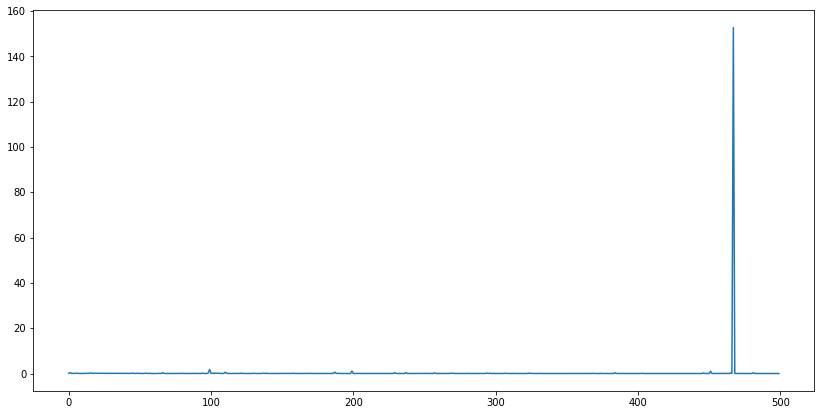

Время обработки:  1276


In [ ]:
# Обучение модели
numEpochs = 100
history = []
curTime = time.time()

model = model.to(device)
model.train()

for epoch in range(numEpochs):
    for i, (x1, x2, y) in enumerate(trainLoader):   
        x1 = x1.type(torch.FloatTensor).to(device)
        x2 = x2.type(torch.FloatTensor).to(device)
        y  = y.type(torch.FloatTensor).to(device)
        
        outputs = model((x1,x2)) 
        loss = criterion(outputs, y)

        optimizer.zero_grad() # обнуляем градиент
        loss.backward()
        optimizer.step()             
        if (i+1) % 100 == 0:
            print('Эпоха: [%d/%d], Шаг: [%d/%d], Ошибка: %.6f' 
                  % (epoch+1, numEpochs, i+1, len(trainData)//batchSize, loss))
            history.append(loss)   
plt.figure(figsize = (14,7))
plt.plot(history)
plt.show()
print('Время обработки: ', round(time.time() - curTime))

## Проверка работы модели

### Через DataLoader

In [ ]:
# Создаем свой датасет
testData = myDataset(xValScaled, xValC01, yValScaled)

# Создаем даталоадер с батчем по всем картинкам сразу
testLoader = torch.utils.data.DataLoader(dataset=testData,
                                           batch_size=1, 
                                           shuffle=True,
                                           num_workers=4)

In [ ]:
correct = 0
total = 0
all_pers = []

model = model.to('cpu') # переводим вычисления на cpu
model.eval() # режим проверки

with torch.no_grad():
  for i, (x1, x2, y) in enumerate(testLoader): # итерируем по проверочному датасету
    if i == 100: break # Берем первые 100 значений
    x1 = x1.type(torch.FloatTensor)
    x2 = x2.type(torch.FloatTensor)
    y = y.type(torch.FloatTensor)
    pred = model((x1, x2))

    predUnscaled = yScaler.inverse_transform(pred.detach().data).flatten()[0]

    yTrainUnscaled = yScaler.inverse_transform(y.detach().data).flatten()[0]
    
    delta = abs(predUnscaled-yTrainUnscaled)
    delta_pers = delta / yTrainUnscaled
    all_pers.append(delta_pers)
    print('Предсказано: ', predUnscaled, 'Реальная цена: ', yTrainUnscaled, 'Разница: ', delta, 'Процент разницы: ', np.round(delta_pers*100, 1))
print('--------------------------------------------------')
print('Средний процент ошибки:', np.round(np.array(all_pers).sum()*100/len(all_pers), 1))

Предсказано:  18428480.0 Реальная цена:  6420713.0 Разница:  12007767.0 Процент разницы:  187.0
Предсказано:  7684351.0 Реальная цена:  7750000.0 Разница:  65649.0 Процент разницы:  0.8
Предсказано:  7897457.5 Реальная цена:  7458925.0 Разница:  438532.5 Процент разницы:  5.9
Предсказано:  5357701.0 Реальная цена:  5900000.0 Разница:  542299.0 Процент разницы:  9.2
Предсказано:  5667043.0 Реальная цена:  7000194.0 Разница:  1333151.0 Процент разницы:  19.0
Предсказано:  6154350.5 Реальная цена:  7000000.0 Разница:  845649.5 Процент разницы:  12.1
Предсказано:  6768449.5 Реальная цена:  7198400.0 Разница:  429950.5 Процент разницы:  6.0
Предсказано:  11119089.0 Реальная цена:  8500000.0 Разница:  2619089.0 Процент разницы:  30.8
Предсказано:  7538593.5 Реальная цена:  7417370.0 Разница:  121223.5 Процент разницы:  1.6
Предсказано:  7285801.5 Реальная цена:  5400000.0 Разница:  1885801.5 Процент разницы:  34.9
Предсказано:  9444967.0 Реальная цена:  7000000.0 Разница:  2444967.0 Процент 

**Вывод:** создана регрессионная модель для оценки стоимости квартир на PyTorch.